# Lecture 3: Differentiable fluid simulation

- INFO8010 Deep Learning, Gilles Louppe
- Lecture 3: [Automatic differentiation](https://glouppe.github.io/info8010-deep-learning/?p=lecture3.md)

This notebook demonstrates that **PyTorch is a differentiable programming language**, not just a deep learning library. Any computation built from PyTorch tensors can be differentiated with `.backward()`.

We implement a 2D fluid simulator from scratch using only standard PyTorch operations, then backpropagate through the entire simulation to optimize initial conditions.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## Part 1: Differentiable fluid simulation

We implement a 2D incompressible Navier-Stokes solver using only standard PyTorch operations. The simulator has three core components:

1. **Advection**: move quantities along the velocity field (semi-Lagrangian: trace backwards, bilinear interpolation)
2. **Projection**: enforce incompressibility by solving for pressure (iterative Gauss-Seidel)
3. **Boundary conditions**: inject wind and smoke from the left wall

Because every operation uses PyTorch tensors, the entire simulation is automatically differentiable.

In [2]:
def gaussian_blur(x, sigma):
    """2D Gaussian blur via separable convolution (differentiable)."""
    r = int(4 * sigma + 0.5)
    k = torch.arange(-r, r + 1, dtype=x.dtype, device=x.device)
    k = torch.exp(-0.5 * k**2 / sigma**2)
    k = k / k.sum()
    k2d = (k[:, None] * k[None, :]).unsqueeze(0).unsqueeze(0)
    return F.conv2d(F.pad(x[None, None], (r,r,r,r), 'reflect'), k2d)[0, 0]


def advect(f, vx, vy):
    """Semi-Lagrangian advection: trace backwards, bilinear interpolation."""
    h, w = f.shape
    gy, gx = torch.meshgrid(torch.arange(h, dtype=f.dtype, device=f.device),
                             torch.arange(w, dtype=f.dtype, device=f.device), indexing='ij')
    sy, sx = gy - vy, gx - vx  # source positions
    iy, ix = sy.long(), sx.long()
    fy, fx = sy - iy.float(), sx - ix.float()

    iy0, iy1 = iy % h, (iy + 1) % h
    ix0, ix1 = ix % w, (ix + 1) % w
    return ((1-fy) * ((1-fx)*f[iy0,ix0] + fx*f[iy0,ix1])
              + fy * ((1-fx)*f[iy1,ix0] + fx*f[iy1,ix1]))


def diffuse_into(f, mask, sigma):
    """Extend field values smoothly into the obstacle for continuous BCs."""
    free = 1 - mask
    return free * f + mask * gaussian_blur(f * free, sigma) / (gaussian_blur(free, sigma) + 1e-8)


def project(vx, vy, mask, sigma):
    """Pressure projection for incompressibility (iterative Gauss-Seidel)."""
    div = -0.5 * (torch.roll(vx,-1,1) - torch.roll(vx,1,1)
                + torch.roll(vy,-1,0) - torch.roll(vy,1,0))
    div = diffuse_into(div, mask, sigma)
    p = torch.zeros_like(vx)
    for _ in range(50):
        p = (div + torch.roll(p,1,1) + torch.roll(p,-1,1)
                 + torch.roll(p,1,0) + torch.roll(p,-1,0)) / 4
        p = diffuse_into(p, mask, sigma)
    vx = (vx - 0.5 * (torch.roll(p,-1,1) - torch.roll(p,1,1))) * (1 - mask)
    vy = (vy - 0.5 * (torch.roll(p,-1,0) - torch.roll(p,1,0))) * (1 - mask)
    return vx, vy


def apply_bcs(fields, names, h, w, wind, k=3):
    """Enforce inlet boundary conditions (left wall + top wall)."""
    out = []
    for name, f in zip(names, fields):
        left = torch.zeros(h, k, dtype=f.dtype, device=f.device)
        top = torch.zeros(k, w, dtype=f.dtype, device=f.device)
        if name == 'vx':    left += wind
        if name == 'upper': left[h//4 : h//2] = 1.0
        if name == 'lower': left[h//2 : 3*h//4] = 1.0
        f = torch.cat([top, f[k:]], dim=0)
        f = torch.cat([left, f[:, k:]], dim=1)
        out.append(f)
    return out


def make_mask(params, h, w):
    """Per-pixel learnable obstacle: sigmoid(params) inside a bounding region."""
    region = torch.zeros(h, w, device=params.device)
    region[int(.3*h):int(.68*h), int(.12*w):int(.62*w)] = 1.0
    return torch.sigmoid(params.view(h, w)) * region


def simulate(h, w, steps, wind, sigma, vx, vy, mask):
    """Run the wind tunnel simulation with two smoke tracers."""
    upper = torch.zeros_like(vx); upper[h//4 : h//2] = 1.0
    lower = torch.zeros_like(vx); lower[h//2 : 3*h//4] = 1.0

    vx, vy = project(vx, vy, mask, sigma)

    for _ in range(steps):
        vx, vy = project(advect(vx, vx, vy), advect(vy, vx, vy), mask, sigma)
        upper = advect(upper, vx, vy) * (1 - mask)
        lower = advect(lower, vx, vy) * (1 - mask)
        vx, vy, upper, lower = apply_bcs(
            [vx, vy, upper, lower], ['vx', 'vy', 'upper', 'lower'], h, w, wind)

    return vx, vy, upper, lower

## Part 2: Objective and optimization

The obstacle is represented as a **per-pixel learnable mask**: each pixel has a learnable parameter, passed through a sigmoid to produce a soft occupancy in $[0, 1]$. A fixed bounding region constrains where the obstacle can exist.

We maximize the **lift-to-drag ratio** using gradient ascent:
1. Build the obstacle mask from current parameters
2. Run the full fluid simulation (20 time steps)
3. Measure lift (vertical momentum change) and drag (horizontal momentum change)
4. Backpropagate through the entire simulation to get gradients

Because every operation is differentiable, `loss.backward()` computes gradients of the lift/drag ratio with respect to every pixel of the obstacle.

In [ ]:
# Simulation parameters
H, W = 50, 75          # grid size
STEPS = 20             # simulation steps per evaluation
OPT_STEPS = 100         # optimization steps
WIND = 1.0             # inlet wind speed
SIGMA = 1.0            # filter width for boundary diffusion
LR = 1e3               # learning rate (gradient ascent)
SEED = 0

torch.manual_seed(SEED)
vx0 = WIND * torch.ones(H, W, device=device)
vy0 = torch.zeros_like(vx0)
params = 0.1 * torch.rand(H * W, device=device) - 1
params.requires_grad_(True)

tensor([-0.9601, -0.9483, -0.9975,  ..., -0.9296, -0.9961, -0.9421],
       device='cuda:0', requires_grad=True)

In [7]:
def objective(params):
    mask = make_mask(params, H, W)
    fvx, fvy, _, _ = simulate(H, W, STEPS, WIND, SIGMA, vx0, vy0, mask)
    lift = -fvy.mean()
    drag = (fvx - vx0).mean()
    return lift / drag

# Record initial state
with torch.no_grad():
    mask0 = make_mask(params, H, W)
    _, _, upper0, lower0 = simulate(H, W, STEPS, WIND, SIGMA, vx0, vy0, mask0)
    initial = (upper0.cpu(), lower0.cpu(), mask0.cpu())

# Optimization loop
history = []  # (step, L/D)
snapshots = {}  # step -> (upper, lower, mask)

t0 = time.time()
for i in range(OPT_STEPS + 1):
    loss = objective(params)
    loss.backward()
    with torch.no_grad():
        params += LR * params.grad   # gradient ascent
        params.grad.zero_()
    history.append((i, loss.item()))

    if i in (OPT_STEPS // 2, OPT_STEPS):
        with torch.no_grad():
            mask_i = make_mask(params, H, W)
            _, _, upper_i, lower_i = simulate(H, W, STEPS, WIND, SIGMA, vx0, vy0, mask_i)
            snapshots[i] = (upper_i.cpu(), lower_i.cpu(), mask_i.cpu())

    if i % 10 == 0:
        print(f'step {i:3d}  L/D = {loss.item():.3f}  ({time.time()-t0:.1f}s)')
        t0 = time.time()

step   0  L/D = -0.003  (1.0s)
step  10  L/D = 0.067  (11.1s)
step  20  L/D = 0.129  (11.0s)
step  30  L/D = 0.180  (11.1s)
step  40  L/D = 0.212  (11.8s)
step  50  L/D = 0.230  (11.5s)
step  60  L/D = 0.242  (11.6s)
step  70  L/D = 0.251  (11.8s)
step  80  L/D = 0.257  (11.5s)


## Part 3: Visualization

We render the flow field as an RGB image: yellow smoke from the upper inlet, teal smoke from the lower inlet, and the obstacle in purple.

In [8]:
BG    = torch.tensor([0.98, 0.98, 0.96])   # warm white
CUPPER = torch.tensor([0.99, 0.81, 0.15])   # yellow (upper smoke)
CLOWER = torch.tensor([0.16, 0.50, 0.73])   # teal   (lower smoke)
COBS   = torch.tensor([0.27, 0.00, 0.33])   # purple (obstacle)

def render(upper, lower, mask):
    """Composite smoke and obstacle into an RGB frame."""
    h, w = upper.shape
    img = BG.view(1, 1, 3).expand(h, w, 3).clone()
    for smoke, color in [(upper, CUPPER), (lower, CLOWER)]:
        a = smoke.clamp(0, 1).unsqueeze(-1)
        img = img * (1 - a) + color * a
    a = mask.clamp(0, 1).unsqueeze(-1)
    img = img * (1 - a) + COBS * a
    return img

### Shape evolution

Starting from a random blob, the optimizer carves out an airfoil shape with a positive angle of attack — exactly what maximizes lift relative to drag.

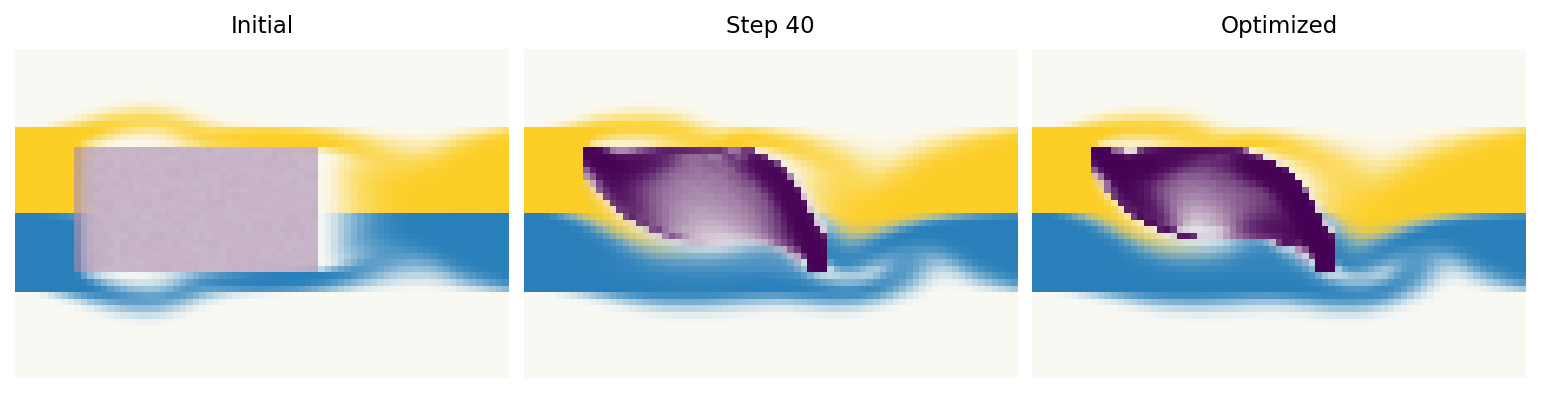

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), dpi=150)
mid = OPT_STEPS // 2
for ax, title, data in zip(axes,
        ['Initial', f'Step {mid}', 'Optimized'],
        [initial, snapshots[mid], snapshots[OPT_STEPS]]):
    upper, lower, mask = data
    frame = render(upper, lower, mask).clamp(0, 1).numpy()
    ax.imshow(frame, interpolation='nearest', cmap='gray')
    ax.set_title(title, fontsize=11, fontweight='medium', pad=8)
    ax.axis('off')
plt.subplots_adjust(wspace=0.03)
plt.show()

### Optimization progress

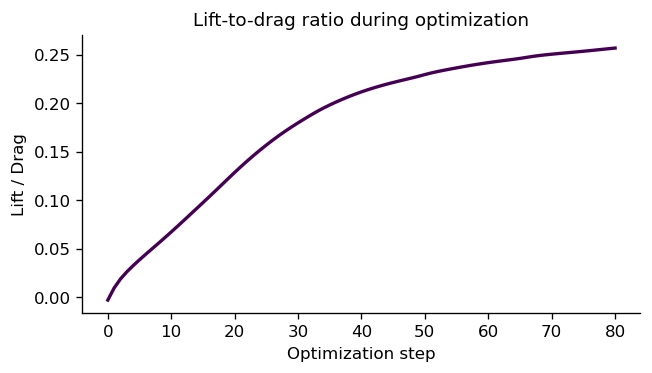

In [10]:
steps, lds = zip(*history)
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
ax.plot(steps, lds, color=COBS.numpy(), linewidth=2)
ax.set_xlabel('Optimization step')
ax.set_ylabel('Lift / Drag')
ax.set_title('Lift-to-drag ratio during optimization', fontsize=11, fontweight='medium')
ax.spines[['top', 'right']].set_visible(False)
plt.show()

## Takeaway

We never defined any gradients by hand. We simply wrote a physics simulation using PyTorch tensors, and `.backward()` gave us the gradients we needed to optimize the wing shape.

This is the power of **automatic differentiation**: it turns any differentiable computation into an optimization problem. The same mechanism that trains neural networks can optimize physical systems, inverse problems, scientific simulations, and much more.